!["Logo"](https://github.com/Fortuz/rl_education/blob/main/assets/logo.png?raw=1)

Created by **Zoltán Barta**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/DQN/cnn_and_wrapper_example.ipynb)


# Introduction to Convolutional Neural Networks (CNNs) in Reinforcement Learning

In reinforcement learning (RL), agents often interact with environments through raw pixel inputs, such as RGB image frames from a camera or game screen. These high-dimensional observations contain rich information but are not directly suitable for traditional policy networks like multilayer perceptrons (MLPs), which expect compact, structured input.

This is where **Convolutional Neural Networks (CNNs)** come into play.

CNNs are used to **extract spatial features** from image inputs and convert them into lower-dimensional embeddings that are more meaningful for decision-making. In RL settings like Atari environments (e.g., Pong, Breakout), agents receive stacks of raw image frames (typically 84x84 pixels) as input. A CNN can process these stacked frames to produce a feature vector, which is then passed to an MLP that outputs the final action logits.

### When to Use CNNs in RL
Use CNNs when:
- The observation space includes images or video frames (e.g. `Box(84, 84, 3)` or frame stacks like `Box(4, 84, 84)`).
- The spatial layout of pixels encodes important information (e.g. object positions, motion).
- You want to reduce high-dimensional input into a compact state representation for downstream use in the policy.

---

### Example: CNN + MLP Policy

Below is a typical setup for an RL agent using a CNN to process visual input, followed by an MLP head that maps the features to actions.


In [1]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py) 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels=4, feature_dim=512):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7 * 7 * 64, feature_dim)  # assuming input is 84x84

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.fc(x)

In [3]:
class MlpPolicy(nn.Module):

    def __init__(self, n_observations, n_actions,num_hidden=128):
        super(MlpPolicy, self).__init__()
        self.layer1 = nn.Linear(n_observations, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.cnn = CNNFeatureExtractor()
        self.mlp = MlpPolicy(512, action_dim)

    def forward(self, x):
        features = self.cnn(x)
        return self.mlp(features)

# Understanding Gymnasium Wrappers in Reinforcement Learning

In reinforcement learning, the environment plays a central role in training an agent. But often, the raw environment provided by a simulator (like those in Gymnasium) isn't in the ideal format for learning. You may want to preprocess observations, modify rewards, stack frames, or even track episode statistics.

This is where **Gymnasium wrappers** come in.

## What Are Wrappers?

Wrappers in Gymnasium are a powerful and modular way to **extend or modify the behavior of environments** without changing their core logic. They act like layers wrapped around the environment — intercepting and potentially altering the inputs and outputs of the environment’s key methods: `reset()`, `step()`, `render()`, etc.

A wrapper is essentially a class that takes an environment as input and returns a modified environment that behaves differently in useful ways.

## Why and When Should You Use Wrappers?

You should use wrappers when:
- You want to **preprocess visual inputs** (e.g. grayscale, resize).
- You need to **stack frames** to give your agent temporal awareness.
- You want to **normalize rewards or observations**.
- You need to **clip actions or rewards** to stabilize training.
- You want to **monitor performance** or collect stats across episodes.

Wrappers keep your code clean and modular. Instead of writing preprocessing logic into the agent or policy network, you "wrap" the environment and keep everything nicely separated.

## How Do Wrappers Work?

Here’s a basic example of using built-in Gymnasium wrappers:


Raw Env
Obs shape: (210, 160, 3)
Obs space: Box(0, 255, (210, 160, 3), uint8)


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


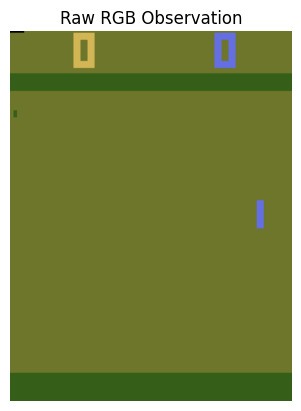

In [5]:
# Helper to show one frame
def show_frame(frame, title=""):
    plt.imshow(frame, cmap='gray' if len(frame.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

# === 1. Raw Pong Env ===
env = gym.make("ALE/Pong-v5", frameskip=1, repeat_action_probability=0.0)
obs, info = env.reset()

print("Raw Env")
print("Obs shape:", obs.shape)
print("Obs space:", env.observation_space)
show_frame(obs, title="Raw RGB Observation")

After AtariPreprocessing
Obs shape: (84, 84)
Obs space: Box(0, 255, (84, 84), uint8)


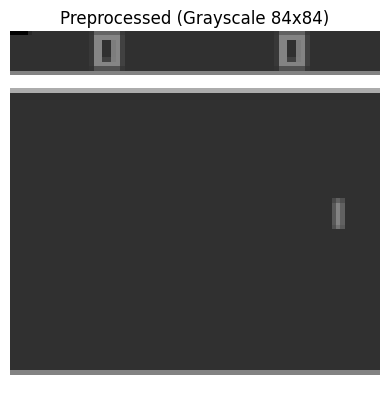

In [6]:
# === 2. Apply AtariPreprocessing ===
from gymnasium.wrappers import AtariPreprocessing
env = AtariPreprocessing(env, frame_skip=4, screen_size=84, terminal_on_life_loss=True)
obs, info = env.reset()

print("After AtariPreprocessing")
print("Obs shape:", obs.shape)
print("Obs space:", env.observation_space)
show_frame(obs, title="Preprocessed (Grayscale 84x84)")

After FrameStackObservation
Obs shape: (4, 84, 84)
Obs space: Box(0, 255, (4, 84, 84), uint8)


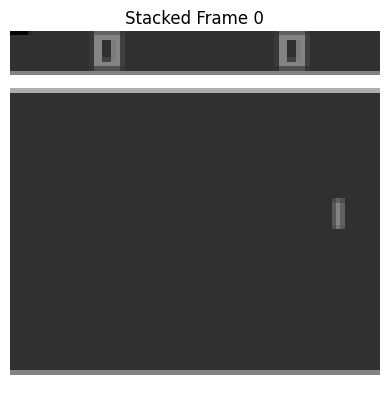

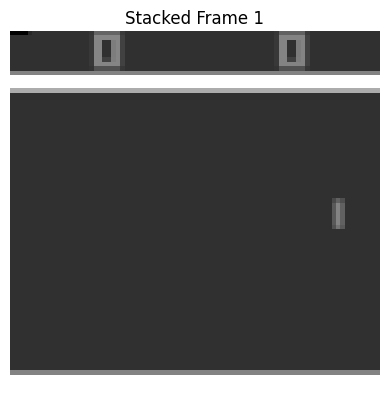

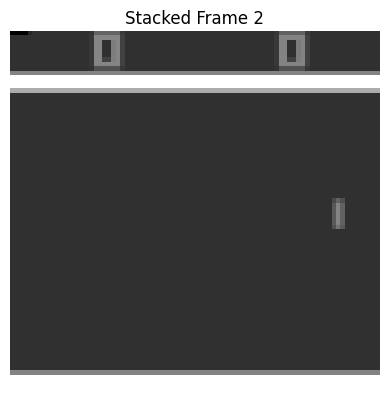

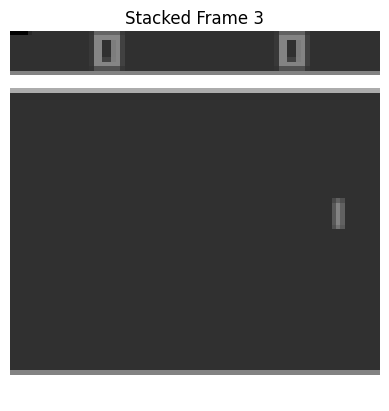

In [7]:
# === 3. FrameStackObservation ===
from gymnasium.wrappers import FrameStackObservation

env = FrameStackObservation(env, stack_size=4)
obs, info = env.reset()

print("After FrameStackObservation")
print("Obs shape:", obs.shape)
print("Obs space:", env.observation_space)

# Show each stacked frame
for i in range(4):
    show_frame(np.array(obs[i]), title=f"Stacked Frame {i}")

In [8]:
# === 4. Add TimeLimit ===
from gymnasium.wrappers import TimeLimit

obs, info = env.reset()

print("Before TimeLimit")
for t in range(10_000):
    observation, reward, terminated,truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    if done:
        print(f"Episode finished after {t + 1} steps")
        break

env = TimeLimit(env, max_episode_steps=300)
obs, info = env.reset()

print("After TimeLimit")
print("This wrapper enforces a max of 1000 steps per episode.")

for i in range(1200):
    observation, reward, terminated,truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    if done:
        print(f"Episode finished after {i + 1} steps")
        break

Before TimeLimit
Episode finished after 977 steps
After TimeLimit
This wrapper enforces a max of 1000 steps per episode.
Episode finished after 300 steps
